In [11]:
import pandas_datareader as pdr
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import dataframe_image as dfi
import seaborn as sns
from pylab import *

#EWO = Elliott Wave Oscillator, which is the difference between 5-day SMA and 35-day SMA

In [12]:
#SMA_longer-term: 50~130 days, n-day Closing Price_slope: 50~130 days

profit_list = [[] for _ in range(81)]
signal_num_list = [[] for _ in range(81)]
current = 0

def lobf(x):
            line_fitter = LinearRegression()
            line_fitter.fit(np.array(x.index).reshape(-1 , 1), x.values)
            return line_fitter.coef_

target_market = 'SPY'
start_date = '2010-06-28'
end_date = '2019-06-28'
sp500_original = pdr.get_data_yahoo(target_market, start_date, end_date)

for m in range(50, 131):
    for n in range(50, 131):
        sp500 = sp500_original.copy()
        day = np.arange(1, len(sp500) + 1)
        sp500['Day'] = day 
        sp500['fast_moving'] = sp500['Close'].rolling(2).mean()   #Column for 5-day SMA
        sp500['slow_moving'] = sp500['Close'].rolling(45).mean() #Column for 35-day SMA
        sp500['longer_term'] = sp500['Close'].rolling(m).mean() #Column for 100-day SMA
        sp500['EWO'] = sp500['fast_moving'] - sp500['slow_moving']     #Column for EWO
        
        sp500 = sp500[['Day', 'Open', 'Close', 'fast_moving', 'slow_moving', 'longer_term', 'EWO']]
        sp500 = sp500.reset_index()
        sp500 = sp500.set_index('Day')

        #Check whether EWO of each day is over a certain positive value, 
        #which is 1% of the closing price(value 1 = Yes, value 0 = No)
        sp500['Filter1'] = np.where(sp500['EWO'] > sp500['fast_moving']/100, 1, 0)
        sp500['Filter2'] = np.where(sp500['EWO'].rolling(5).apply(lobf) > 0, 1, 0)
        sp500['Filter3'] = np.where(sp500['Close'] > sp500['longer_term'], 1, 0) #Indicate where the price is in uptrend
        sp500.dropna(inplace=True)

        #Indicate where the EWO's slope is negative AND where the price is in downtrend
        sp500['Exit1'] = np.where(sp500['EWO'].rolling(5).apply(lobf) < 0, -1, 0)
        sp500['Exit2'] = np.where(sp500['Close'].rolling(n).apply(lobf) < 0, -1, 0)


        #sp500_buy dataframe refers to the buy signals, where all the filters are satistfied
        condition1 = (sp500['Filter1'] == 1)
        condition2 = (sp500['Filter2'] == 1)
        condition3 = (sp500['Filter3'] == 1)

        sp500_buy = sp500.loc[condition1&condition2&condition3]

        budget = 100000 # Initial Budget = 100,000 USD
        buy_list = []
        sell_list = []
        sold_day = 0
        bought_amount = 0

        for i in range(len(list(sp500_buy.index))-1): #Iterate the elements in sp500_buy, which contains buy signals
            if sold_day > list(sp500_buy.index)[i]+1:
                continue
            if bought_amount == 0:
                bought_day = list(sp500_buy.index)[i]+1 #Buy the stock at the next morning's open price
                buy_list.append(bought_day)
                bought_price = sp500.loc[bought_day, 'Open']
                bought_amount = budget // bought_price #Buy as many as the budget allows at that price
                budget -= bought_amount * bought_price #Remaining budget after having a long position


            #Beginning from the day of long position until the subsequent day of a buy signal, 
            #check whether there's any exit sign; 
            #i.e. either the slope of EWO is negative or the stock price is in downtrend 
            for j in range(bought_day, sp500.iloc[[-1]].index[0]):
                if (sp500.loc[j, 'Exit1'] == -1) and (sp500.loc[j, 'Exit2'] == -1) or \
                    (j == sp500.iloc[[-1]].index[0]-1):
                    sold_price = sp500.loc[j+1, 'Open']
                    sold_day = j+1
                    sell_list.append(sold_day)
                    budget += bought_amount * sold_price
                    #Reset the parameter
                    bought_amount = 0
                    break


        profit_list[m-50].append(round(budget))
        signal_num_list[m-50].append(len(buy_list))
        current += 1
        if current % 500 == 0:
            print(current, "out of 6561 combinations are tested\n")

print(profit_list)
print(signal_num_list)

max_profit = max(map(max, profit_list))
print(max_profit)

max_trade = max(map(max, signal_num_list))
print(max_trade)

for i in range(len(profit_list)): #81
    for j in range(len(profit_list[i])): #81
        if profit_list[i][j] == max_profit:
            print(i+50)
            print(j+50)
            # 저번에 해본걸로는 50, 125나옴

500 out of 6561 combinations are tested

1000 out of 6561 combinations are tested

1500 out of 6561 combinations are tested

2000 out of 6561 combinations are tested

2500 out of 6561 combinations are tested

3000 out of 6561 combinations are tested

3500 out of 6561 combinations are tested

4000 out of 6561 combinations are tested

4500 out of 6561 combinations are tested

5000 out of 6561 combinations are tested

5500 out of 6561 combinations are tested

6000 out of 6561 combinations are tested

6500 out of 6561 combinations are tested

[[209861, 195306, 196705, 210531, 209090, 208805, 209843, 208638, 214753, 215418, 209149, 204103, 200917, 199024, 199166, 199986, 204236, 204514, 195069, 193812, 188519, 186035, 181937, 190011, 188217, 186540, 193274, 192479, 180925, 177430, 174763, 175871, 179004, 189640, 191850, 194130, 188581, 192752, 190680, 188172, 189199, 190127, 185532, 213258, 216352, 217710, 218167, 224028, 238966, 236386, 236606, 232065, 225704, 208350, 211700, 214385, 21313

In [22]:
seaborn_heatmap = pd.DataFrame({'M':[], 'N':[], 'Value':[]})
for i in range(81):
    for j in range(81):
        df = pd.DataFrame({'M':[int(i+50)], 'N':[int(j+50)], 'Value':[profit_list[i][j]]})
        seaborn_heatmap = seaborn_heatmap.append(df, ignore_index = True)
            
seaborn_heatmap = seaborn_heatmap.pivot('M', 'N', 'Value')

/var/folders/5_/kj_nfskn1xl2q2rjqnct9v0w0000gn/T/ipykernel_16713/3095079781.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  seaborn_heatmap = seaborn_heatmap.append(df, ignore_index = True)


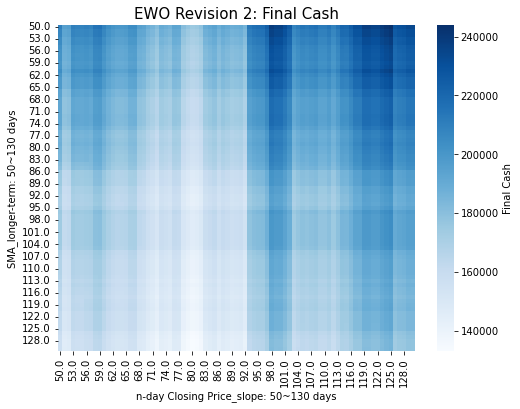

In [37]:
plt.figure(figsize=(8, 6))
ax = sns.heatmap(seaborn_heatmap, cmap='Blues', cbar_kws={'label': 'Final Cash'})
plt.title('EWO Revision 2: Final Cash', fontsize = 15)
plt.xlabel('n-day Closing Price_slope: 50~130 days')
plt.ylabel('SMA_longer-term: 50~130 days')
plt.savefig('EWO Revision 2: Final Cash.png', dpi=300)
plt.show()

In [25]:
seaborn_heatmap_trade_num = pd.DataFrame({'M':[], 'N':[], 'Value':[]})
for i in range(81):
    for j in range(81):
        df = pd.DataFrame({'M':[i+50], 'N':[j+50], 'Value':[signal_num_list[i][j]]})
        seaborn_heatmap_trade_num = seaborn_heatmap_trade_num.append(df, ignore_index = True)
            
seaborn_heatmap_trade_num = seaborn_heatmap_trade_num.pivot('M', 'N', 'Value')

/var/folders/5_/kj_nfskn1xl2q2rjqnct9v0w0000gn/T/ipykernel_16713/1875241131.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  seaborn_heatmap_trade_num = seaborn_heatmap_trade_num.append(df, ignore_index = True)


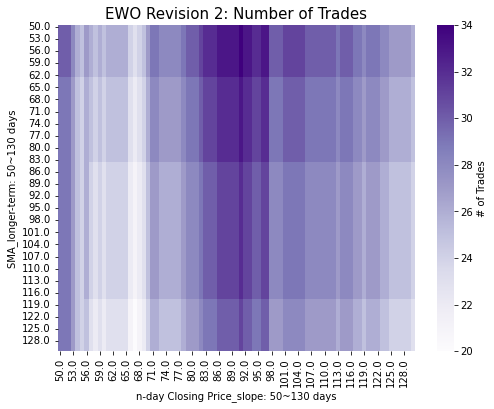

In [39]:
plt.figure(figsize=(8, 6))
ax = sns.heatmap(seaborn_heatmap_trade_num, cmap='Purples', cbar_kws={'label': '# of Trades'})
plt.title('EWO Revision 2: Number of Trades', fontsize = 15)
plt.xlabel('n-day Closing Price_slope: 50~130 days')
plt.ylabel('SMA_longer-term: 50~130 days')
plt.savefig('EWO Revision 2: Number of Trades.png', dpi=300)
plt.show()